# Readme

The purpose of this file is to check that the code is correct and that the models are converging properly.

# Setup

In [1]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import time
import random
import pickle
import json
import itertools
import importlib

/home/mmip/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import sys
sys.path.append ('functions')

import functions as mf
importlib.reload(mf) 

from static_nn_module import RegressionNN

In [3]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [4]:
pd.set_option("display.max_columns", None)

# Data

## Data no embeddings

In [5]:
data_no_embeddings = pd.read_csv("../00_data_preparation/processed_data/data_static_nn_1.csv")

In [6]:
data_no_embeddings = data_no_embeddings.drop(['Unnamed: 0'], axis = 1)

In [7]:
data_no_embeddings.shape

(699, 37)

In [8]:
data_no_embeddings.head (2)

,e.cum,e.rel,pmid,meas.tech,country,inst,ct,tan.app,app.rate,man.dm,man.ph,man.source,t.incorp,air_temp_1,air_temp_2,air_temp_3,air_temp_4,air_temp_5,air_temp_6,wind.2m_1,wind.2m_2,wind.2m_3,wind.2m_4,wind.2m_5,wind.2m_6,rain.rate_1,rain.rate_2,rain.rate_3,rain.rate_4,rain.rate_5,rain.rate_6,app.mthd_bc,app.mthd_bsth,app.mthd_ts,app.mthd_os,incorp_none,incorp_shallow
0,16.4190,0.134461,182,micro met,DK,104,164.99,122.11,31.8,3.7,7.35,0,1000.0,8.20,7.648529,6.766176,5.883824,5.001471,9.389090,8.10,7.494118,6.524706,5.555294,4.585882,5.340230,0.0,0.0,0.0,0.0,0.0,0.047679,1,0,0,0,1,0
1,6.9332,0.118882,183,micro met,DK,104,163.20,58.32,21.6,2.8,7.71,0,1000.0,13.77,13.568793,12.562759,11.489655,10.416552,10.006593,4.31,4.261897,4.021379,3.764828,3.508276,4.141415,0.0,0.0,0.0,0.0,0.0,0.000000,0,1,0,0,1,0


## Data embeddings

In [9]:
data_embeddings = pd.read_csv("../00_data_preparation/processed_data/data_static_nn_2.csv")

In [10]:
data_embeddings = data_embeddings.drop(['Unnamed: 0'], axis = 1)

## Test samples

In [11]:
with open("../00_data_preparation/processed_data/list_train_pmids.json", "r") as f:
    list_train_pmids = json.load(f)

with open("../00_data_preparation/processed_data/list_eval_pmids.json", "r") as f:
    list_eval_pmids = json.load(f)

with open("../00_data_preparation/processed_data/list_test_pmids.json", "r") as f:
    list_test_pmids = json.load(f)

# Models

In [12]:
input_size_no_embeddings = 31
input_size_embeddings = 27

output_size = 1

models = list (range (1, 13))

architecture = [
    [input_size_no_embeddings, 16, output_size],
    [input_size_no_embeddings, 32, 16, output_size],
    [input_size_no_embeddings, 64, 32, 16, output_size],
    [input_size_no_embeddings, 128, 64, 32, 16, output_size],
    [input_size_no_embeddings, 256, 128, 64, 32, 16, output_size],
    [input_size_no_embeddings, 512, 256, 128, 64, 32, 16, output_size],
    [input_size_embeddings, 16, output_size],
    [input_size_embeddings, 32, 16, output_size],
    [input_size_embeddings, 64, 32, 16, output_size],
    [input_size_embeddings, 128, 64, 32, 16, output_size],
    [input_size_embeddings, 256, 128, 64, 32, 16, output_size],
    [input_size_embeddings, 512, 256, 128, 64, 32, 16, output_size],
]

with_embeddings = [False, False, False, False, False, False, True, True, True, True, True, True]

In [13]:
df_models = pd.DataFrame({'model': models, 'architecture' : architecture, 'with_embeddings' : with_embeddings})

In [14]:
df_models

,model,architecture,with_embeddings
0,1,"[31, 16, 1]",False
1,2,"[31, 32, 16, 1]",False
2,3,"[31, 64, 32, 16, 1]",False
3,4,"[31, 128, 64, 32, 16, 1]",False
4,5,"[31, 256, 128, 64, 32, 16, 1]",False
5,6,"[31, 512, 256, 128, 64, 32, 16, 1]",False
6,7,"[27, 16, 1]",True
7,8,"[27, 32, 16, 1]",True
8,9,"[27, 64, 32, 16, 1]",True
9,10,"[27, 128, 64, 32, 16, 1]",True


# Training

In [15]:
pmids_train = list_train_pmids [0]
pmids_eval = list_eval_pmids [0]
pmids_test = list_test_pmids [0]

In [16]:
model_index = 11

architecture = df_models['architecture'][model_index - 1]
with_embeddings = df_models['with_embeddings'][model_index - 1]

if (with_embeddings):
    data = data_embeddings.copy()
    cat_dims = [5, 3, 2]  
    embeddings_dims = [10, 9, 8]  
    input_size = 27

else: 
    data = data_no_embeddings.copy()
    cat_dims = None
    embeddings_dims = None
    input_size = 31

In [17]:
df_models.iloc[model_index - 1]

model                                         11
architecture       [27, 256, 128, 64, 32, 16, 1]
with_embeddings                             True
Name: 10, dtype: object

In [18]:
data_train = data[data['pmid'].isin(pmids_train)]
pmids_train = data_train['pmid'].unique()

data_eval = data[data['pmid'].isin(pmids_eval)]
pmids_eval = data_eval['pmid'].unique()

data_test = data[data['pmid'].isin(pmids_test)]
pmids_test = data_test['pmid'].unique()

n_observations_evaluation_subset = data_eval.shape[0]

n_train = data_train.shape[0]

In [19]:
continuous_variables = ['ct', 'tan.app', 'app.rate', 'man.dm', 'man.ph', 't.incorp', 
                        'air_temp_1', 'air_temp_2', 'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6', 
                        'wind.2m_1', 'wind.2m_2', 'wind.2m_3', 'wind.2m_4', 'wind.2m_5', 'wind.2m_6', 
                        'rain.rate_1', 'rain.rate_2', 'rain.rate_3', 'rain.rate_4', 'rain.rate_5', 'rain.rate_6']

if with_embeddings:
       
    x_cont_train = torch.tensor (data_train [continuous_variables].values, dtype = torch.float32).to(DEVICE)
    x_cat_train = torch.tensor (data_train[['app.mthd', 'incorp', 'man.source']].values, dtype = torch.long).to(DEVICE)
    x_train = [x_cont_train, x_cat_train]
    
    x_cont_eval = torch.tensor (data_eval [continuous_variables].values, dtype = torch.float32).to(DEVICE)
    x_cat_eval = torch.tensor (data_eval[['app.mthd', 'incorp', 'man.source']].values, dtype = torch.long).to(DEVICE)
    x_cat_eval = torch.unbind (x_cat_eval, dim = 1)
    x_eval = [x_cont_eval, x_cat_eval]
    
    x_cont_test = torch.tensor (data_test [continuous_variables].values, dtype = torch.float32).to(DEVICE)
    x_cat_test = torch.tensor (data_test[['app.mthd', 'incorp', 'man.source']].values, dtype = torch.long).to(DEVICE)
    x_cat_test = torch.unbind (x_cat_test, dim = 1)    
    x_test = [x_cont_test, x_cat_test]

else:
    x_train = torch.tensor (data_train.iloc[:,6:].values, dtype = torch.float32).to(DEVICE) 
    x_eval = torch.tensor (data_eval.iloc[:,6:].values, dtype = torch.float32).to(DEVICE) 
    x_test = torch.tensor (data_test.iloc[:,6:].values, dtype = torch.float32).to(DEVICE) 

y_train = torch.tensor (data_train [['e.cum']].values, dtype = torch.float32).to(DEVICE)
y_eval = torch.tensor (data_eval [['e.cum']].values, dtype = torch.float32).to(DEVICE)
y_test = torch.tensor (data_test [['e.cum']].values, dtype = torch.float32).to(DEVICE)

In [20]:
torch.manual_seed(1)

model = RegressionNN(layer_sizes = architecture, 
                     with_embeddings = with_embeddings,
                     cat_dims = cat_dims, 
                     embeddings_dims = embeddings_dims).to(DEVICE)

start_time = time.time()

learning_rate = 0.0001
#num_epochs = 10000
num_epochs = 4000
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.train()  # Set model to training mode
random.seed(1)

all_losses = []
all_mae_eval = []

for epoch in range(num_epochs):

    indices = torch.randperm(n_train)
    
    mini_batches_x, mini_batches_y = mf.generatre_mini_batches (x_train, y_train, with_embeddings, batch_size, n_train, indices)

    all_predictions = []

    for x_batch, y_batch in zip (mini_batches_x, mini_batches_y):

        n_obs_train = y_batch.shape[0]
    
        predictions = model(x_batch)  
    
        loss = torch.sum ((predictions - y_batch) ** 2) / n_obs_train  
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        all_predictions.append(predictions.detach())

    all_predictions = torch.cat(all_predictions, dim = 0)
    all_target_train = torch.cat(mini_batches_y, dim = 0)

    loss = torch.sum (torch.abs(all_predictions - all_target_train)) / n_train
    all_losses.append (loss.item())


    with torch.no_grad():
                    
        predictions_eval = model (x_eval)
        mae = torch.sum (torch.abs (predictions_eval - y_eval)) / n_observations_evaluation_subset

    all_mae_eval.append (mae.item())
    
    if (epoch+1) % (num_epochs / 10) == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

end_time = time.time()

Epoch [400/4000], Loss: 5.5514
Epoch [800/4000], Loss: 4.6611
Epoch [1200/4000], Loss: 4.0812
Epoch [1600/4000], Loss: 3.4566
Epoch [2000/4000], Loss: 3.0810
Epoch [2400/4000], Loss: 2.7496
Epoch [2800/4000], Loss: 2.3931
Epoch [3200/4000], Loss: 2.3072
Epoch [3600/4000], Loss: 2.0862
Epoch [4000/4000], Loss: 2.0674


In [21]:
elapsed_time = end_time - start_time
print(f"Temps d'exécution : {elapsed_time} secondes")

Temps d'exécution : 169.5325059890747 secondes


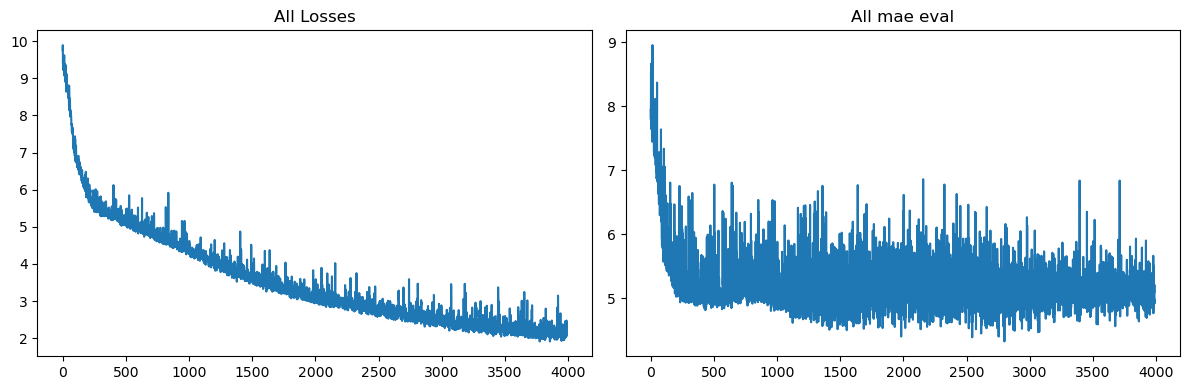

In [22]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4), sharey = False)

axes[0].plot(all_losses[10:])
axes[0].set_title('All Losses')

axes[1].plot(all_mae_eval[10:])
axes[1].set_title('All mae eval')

plt.tight_layout()
plt.show()

In [23]:
x_train_reshaped = [x_train[0], torch.unbind (x_train[1], dim = 1)]

with torch.no_grad():
                
    predictions_test = model (x_test)
    predictions_train = model (x_train_reshaped)

In [24]:
predictions_test.shape

torch.Size([74, 1])

In [25]:
y_test.shape

torch.Size([74, 1])

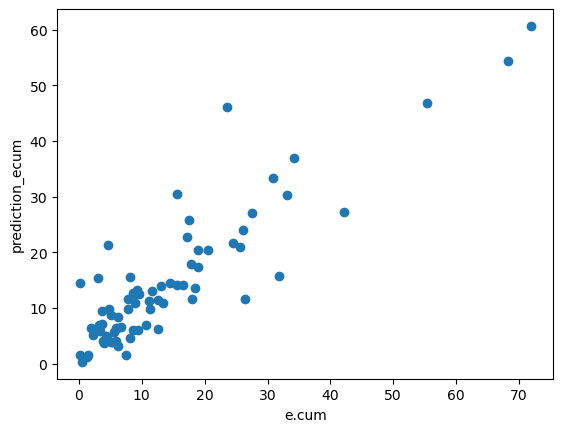

In [26]:
plt.scatter(y_test.to("cpu"), predictions_test.to("cpu"))
plt.xlabel('e.cum') 
plt.ylabel('prediction_ecum') 
plt.show()

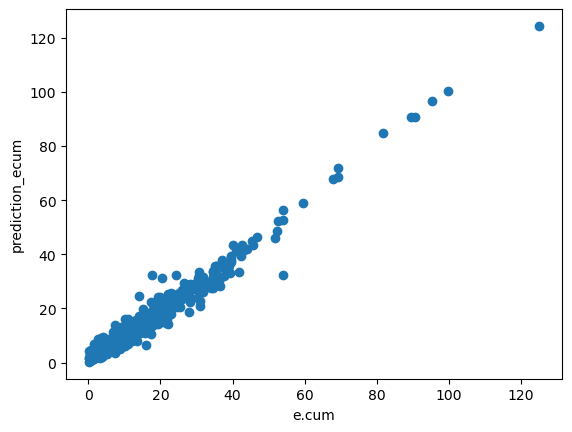

In [27]:
plt.scatter(y_train.to("cpu"), predictions_train.to("cpu"))
plt.xlabel('e.cum') 
plt.ylabel('prediction_ecum')  
plt.show()

# End